### To run this notebook ensure the 64x64_SIGNS.zip file is uploaded directly in Google Drive.

###Connecting to Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Extracting the data from the ZIP File 64X64_SIGNS

In [19]:
import zipfile
import os

# The path to your ZIP file on Google Drive
zip_file_path = '/content/drive/My Drive/64x64_SIGNS.zip'

# Destination folder to extract the contents
extracted_folder_path = '/content/data'

# Extracting the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# To access the contents of the extracted folders (train_signs, test_signs, val_signs)
train_folder_path = os.path.join(extracted_folder_path, '64x64_SIGNS/train_signs')
test_folder_path = os.path.join(extracted_folder_path, '64x64_SIGNS/test_signs')
val_folder_path = os.path.join(extracted_folder_path, '64x64_SIGNS/val_signs')

# Listing the contents of the folders
train_files = os.listdir(train_folder_path)
test_files = os.listdir(test_folder_path)
val_files = os.listdir(val_folder_path)

# Displaying the number of images in each folder
num_train_images = len(train_files)
num_test_images = len(test_files)
num_val_images = len(val_files)

print(f"Number of images in train_signs folder: {num_train_images}")
print(f"Number of images in test_signs folder: {num_test_images}")
print(f"Number of images in val_signs folder: {num_val_images}")


Number of images in train_signs folder: 864
Number of images in test_signs folder: 120
Number of images in val_signs folder: 216


## Importing the necessary libraries

In [4]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np



## Creating a custom class for the Dataset


#### Creating transformations (All images are already resized)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class HandSignDataset(Dataset):
    def __init__(self,data_folder,transformation):
      self.data_folder = data_folder
      self.transformation = transformation
      self.file_list = os.listdir(self.data_folder)
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.file_list[idx])
        image = Image.open(img_name)
        label = int(os.path.splitext(self.file_list[idx])[0].split('_')[0]) # Extracting label from the filename
        if self.transformation:
            image = self.transformation(image)
        return image, label

In [8]:
EPOCHS=25

## Creating paths to the train,test and validation data

In [9]:
train_data_path = '/content/data/64x64_SIGNS/train_signs'
test_data_path = '/content/data/64x64_SIGNS/test_signs'
val_data_path = '/content/data/64x64_SIGNS/val_signs'

## Creating the datasets

In [11]:
train_dataset = HandSignDataset(train_data_path,transform)
test_dataset = HandSignDataset(test_data_path,transform)
val_dataset = HandSignDataset(val_data_path,transform)

## Creating dataloaders

In [12]:
train_batch_size=32
test_batch_size=32
val_batch_size=32
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)

## Creating the Neural Network Model

In [13]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        # Three dense layers with ReLU activation
        self.input_layer = nn.Linear(64 * 64 * 3, 1024)  # Input size: 64x64x3
        self.relu1 = nn.ReLU()
        self.hidden_layer1 = nn.Linear(1024, 12288)
        self.relu2 = nn.ReLU()
        self.hidden_layer2 = nn.Linear(12288, 6)  # Output layer with 6 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.input_layer(x)
        x = self.relu1(x)
        x = self.hidden_layer1(x)
        x = self.relu2(x)
        x = self.hidden_layer2(x)
        return x

In [14]:

# Initialize the model
model = NNModel()

# Print the model architecture
print(model)

NNModel(
  (input_layer): Linear(in_features=12288, out_features=1024, bias=True)
  (relu1): ReLU()
  (hidden_layer1): Linear(in_features=1024, out_features=12288, bias=True)
  (relu2): ReLU()
  (hidden_layer2): Linear(in_features=12288, out_features=6, bias=True)
)


## Common function for evaluating the model

In [15]:
def evaluate_per_epoch(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0  # Variable to accumulate the total loss

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluation'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()  # Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(loader)  # Calculate the average loss

    return accuracy, average_loss

##Training the model with L2 Penalty and Adam optimizer

In [16]:
num_epochs=EPOCHS
weight_decay=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

In [18]:
# Training loop with evaluation and plotting
train_losses_l2 = []
val_losses_l2 = []
val_accuracies_l2 = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate L2-norm penalty
        l2_penalty = 0.0
        for param in model.parameters():
            l2_penalty += torch.norm(param, 2)

        loss += weight_decay * l2_penalty

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses_l2.append(train_loss / len(train_loader))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy, val_loss = evaluate_per_epoch(model, val_loader, criterion)
    val_losses_l2.append(val_loss)
    val_accuracies_l2.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_l2[-1]:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%')


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.68it/s]


Epoch [1/25] - Train Loss: 6.6872 - Val Loss: 1.5000 - Val Accuracy: 31.94%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.49it/s]


Epoch [2/25] - Train Loss: 1.4737 - Val Loss: 1.6259 - Val Accuracy: 37.50%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.70it/s]


Epoch [3/25] - Train Loss: 1.3898 - Val Loss: 1.3030 - Val Accuracy: 45.83%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.02it/s]


Epoch [4/25] - Train Loss: 1.2540 - Val Loss: 1.1361 - Val Accuracy: 50.46%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.02it/s]


Epoch [5/25] - Train Loss: 1.1202 - Val Loss: 1.0691 - Val Accuracy: 53.24%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.08it/s]


Epoch [6/25] - Train Loss: 0.9839 - Val Loss: 1.1401 - Val Accuracy: 55.56%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.38it/s]


Epoch [7/25] - Train Loss: 0.8471 - Val Loss: 0.8401 - Val Accuracy: 70.83%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.92it/s]


Epoch [8/25] - Train Loss: 0.8449 - Val Loss: 1.0048 - Val Accuracy: 59.72%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.67it/s]


Epoch [9/25] - Train Loss: 0.7488 - Val Loss: 1.1233 - Val Accuracy: 59.72%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.96it/s]


Epoch [10/25] - Train Loss: 0.6360 - Val Loss: 0.9807 - Val Accuracy: 63.89%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.77it/s]


Epoch [11/25] - Train Loss: 0.5727 - Val Loss: 0.7953 - Val Accuracy: 69.44%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.41it/s]


Epoch [12/25] - Train Loss: 0.5029 - Val Loss: 0.7723 - Val Accuracy: 75.00%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.55it/s]


Epoch [13/25] - Train Loss: 0.4807 - Val Loss: 1.2159 - Val Accuracy: 62.04%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.58it/s]


Epoch [14/25] - Train Loss: 0.6189 - Val Loss: 0.8911 - Val Accuracy: 68.98%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.59it/s]


Epoch [15/25] - Train Loss: 0.4229 - Val Loss: 0.8050 - Val Accuracy: 76.39%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.68it/s]


Epoch [16/25] - Train Loss: 0.3947 - Val Loss: 0.9678 - Val Accuracy: 70.37%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.32it/s]


Epoch [17/25] - Train Loss: 0.5004 - Val Loss: 0.7087 - Val Accuracy: 77.78%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.57it/s]


Epoch [18/25] - Train Loss: 0.3616 - Val Loss: 0.8702 - Val Accuracy: 71.30%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.17it/s]


Epoch [19/25] - Train Loss: 0.3768 - Val Loss: 0.7901 - Val Accuracy: 77.31%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.45it/s]


Epoch [20/25] - Train Loss: 0.2900 - Val Loss: 0.8644 - Val Accuracy: 74.07%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


Epoch [21/25] - Train Loss: 0.2548 - Val Loss: 0.7924 - Val Accuracy: 79.63%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.38it/s]


Epoch [22/25] - Train Loss: 0.4835 - Val Loss: 1.0367 - Val Accuracy: 76.39%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.34it/s]


Epoch [23/25] - Train Loss: 0.3701 - Val Loss: 0.7298 - Val Accuracy: 77.31%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.40it/s]


Epoch [24/25] - Train Loss: 0.2159 - Val Loss: 0.8051 - Val Accuracy: 79.63%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 16.38it/s]

Epoch [25/25] - Train Loss: 0.2118 - Val Loss: 0.7415 - Val Accuracy: 80.56%


## Testing on the test dataset

In [20]:
test_accuracy_l2, test_loss_l2 = evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with L2-norm penalty: {test_accuracy_l2:.2f}%')
print(f'Test Loss with L2-norm penalty: {np.mean(test_loss_l2):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s]


Test Accuracy with L2-norm penalty: 80.83%
Test Loss with L2-norm penalty: 0.6913


## Plotting the loss and validation accuracy

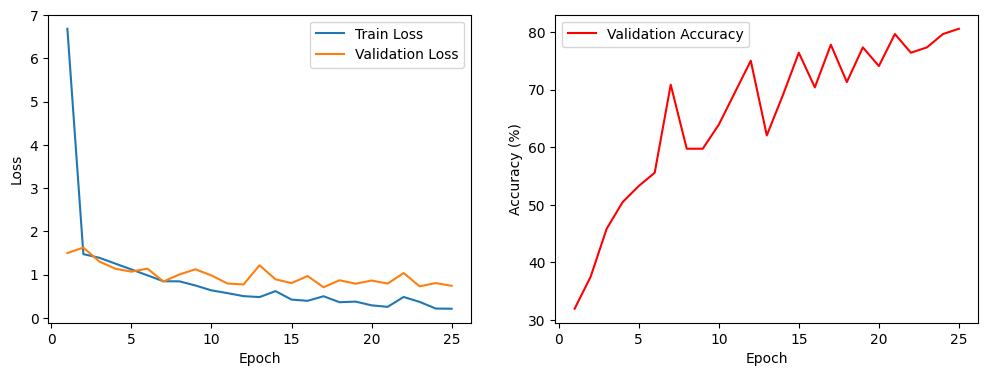

In [21]:
# Determine the x-axis range based on the number of epochs
x_range = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, train_losses_l2[:num_epochs], label='Train Loss')
plt.plot(x_range, val_losses_l2[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range, val_accuracies_l2[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


## Training the model using Early Stopping Regularization  and then running the model

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

In [28]:
def train_with_early_stopping(model, train_loader, val_loader, num_epochs, patience, weight_decay):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    current_patience = 0

    # Store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()

        # Initialize epoch statistics
        train_loss = 0
        total = 0
        correct = 0

        # Iterate over mini-batches in the training loader
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss
            train_loss += loss.item()

            # Track training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader)
        train_acc = correct / total

        # Calculate validation loss and accuracy
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

                # Track validation accuracy
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break

        # Store losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_losses, val_losses, val_accuracies,epoch+1

# Example usage with early stopping
model = NNModel()  # Initialize your model
weight_decay = 0.001  # Adjust the weight decay as needed
patience = 10 # Number of epochs without improvement to wait before early stopping

train_losses_es, val_losses_es, val_accuracies_es,epoch_early_es= train_with_early_stopping(model, train_loader, val_loader, num_epochs=EPOCHS,patience=patience, weight_decay=weight_decay)


Epoch 1/25, Train Loss: 9.4755, Validation Loss: 1.4956, Validation Accuracy: 0.3935
Epoch 2/25, Train Loss: 1.3603, Validation Loss: 1.1811, Validation Accuracy: 0.5046
Epoch 3/25, Train Loss: 1.1509, Validation Loss: 1.0335, Validation Accuracy: 0.5972
Epoch 4/25, Train Loss: 0.9009, Validation Loss: 0.9153, Validation Accuracy: 0.6296
Epoch 5/25, Train Loss: 0.7742, Validation Loss: 0.9598, Validation Accuracy: 0.6481
Epoch 6/25, Train Loss: 0.5978, Validation Loss: 0.9139, Validation Accuracy: 0.6852
Epoch 7/25, Train Loss: 0.6060, Validation Loss: 0.8187, Validation Accuracy: 0.7269
Epoch 8/25, Train Loss: 0.4886, Validation Loss: 0.8277, Validation Accuracy: 0.7407
Epoch 9/25, Train Loss: 0.5012, Validation Loss: 0.8864, Validation Accuracy: 0.7593
Epoch 10/25, Train Loss: 0.5009, Validation Loss: 1.2905, Validation Accuracy: 0.5833
Epoch 11/25, Train Loss: 0.3712, Validation Loss: 0.8930, Validation Accuracy: 0.7407
Epoch 12/25, Train Loss: 0.3045, Validation Loss: 0.8185, Valid

##Plotting the loss and validation accuracy

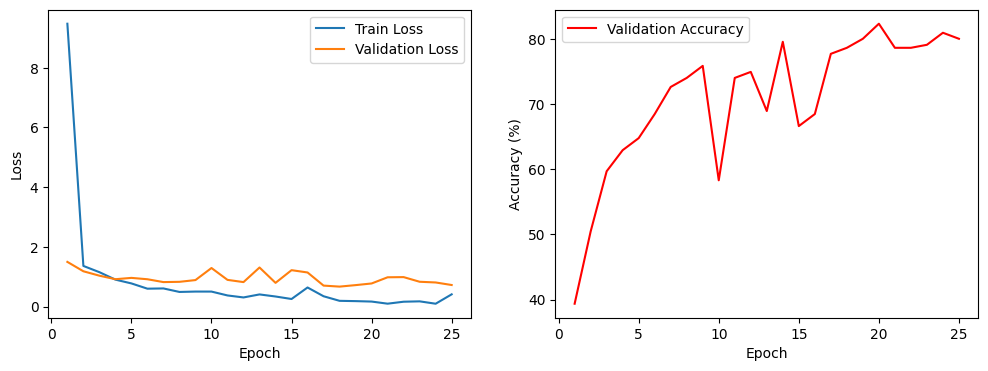

In [30]:
# Determine the x-axis range based on the number of epochs
x_range=range(1,epoch_early_es + 1)
val_accuracies_es_100 = [x * 100 for x in val_accuracies_es]
# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, train_losses_es[:epoch_early_es], label='Train Loss')
plt.plot(x_range, val_losses_es[:epoch_early_es], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range, val_accuracies_es_100[:epoch_early_es], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Testing on the test set

In [27]:
test_accuracy_es, test_loss_es = evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with Early stopping penalty: {test_accuracy_es:.2f}%')
print(f'Test Loss with Early stopping penalty: {np.mean(test_loss_es):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s]


Test Accuracy with L2-norm penalty: 71.67%
Test Loss with L2-norm penalty: 0.8736


## Implementing Data Augmentation Regularization

In [48]:
# Define data augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(10),  # Rotate by a random angle between -10 and 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomAffine(0, translate=(0.1, 0.1))  # Random affine transformation

])

In [49]:
def custom_collate(batch):
    # Use transforms.ToTensor() to convert images to tensors
    transform = transforms.Compose([transforms.ToTensor()])
    images, labels = zip(*batch)
    images = [transform(img) for img in images]
    images = torch.stack(images)  # Convert list of images to a tensor
    labels = torch.tensor(labels)  # Convert list of labels to a tensor
    return images, labels

## Creating an augmented train dataset

In [50]:
aug_train_dataset = HandSignDataset(train_data_path, augmentation_transforms)

In [51]:
batch_size = 32
aug_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)


## Training and evaluating the model

In [52]:
model = NNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = EPOCHS
train_losses_aug = []
val_losses_aug = []
val_accuracies_aug = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(aug_train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate and store the training loss
    train_losses_aug.append(running_loss / len(aug_train_loader))

    # Evaluate the model on the validation set
    val_accuracy, val_loss = evaluate_per_epoch(model, val_loader, criterion)
    val_losses_aug.append(val_loss)
    val_accuracies_aug.append(val_accuracy)

    # Print and log the results
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_aug[-1]:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%')


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.96it/s]


Epoch [1/25] - Train Loss: 397.1066 - Val Loss: 57.2900 - Val Accuracy: 17.13%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


Epoch [2/25] - Train Loss: 12.3425 - Val Loss: 17.8025 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


Epoch [3/25] - Train Loss: 4.9722 - Val Loss: 5.3710 - Val Accuracy: 16.67%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


Epoch [4/25] - Train Loss: 2.3315 - Val Loss: 4.6499 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.72it/s]


Epoch [5/25] - Train Loss: 6.6979 - Val Loss: 73.1976 - Val Accuracy: 16.67%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.12it/s]


Epoch [6/25] - Train Loss: 5.4630 - Val Loss: 8.1217 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.10it/s]


Epoch [7/25] - Train Loss: 4.1061 - Val Loss: 6.1647 - Val Accuracy: 10.19%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.05it/s]


Epoch [8/25] - Train Loss: 1.8077 - Val Loss: 6.6155 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.35it/s]


Epoch [9/25] - Train Loss: 1.8048 - Val Loss: 6.4768 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.40it/s]


Epoch [10/25] - Train Loss: 1.7977 - Val Loss: 6.7038 - Val Accuracy: 13.89%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


Epoch [11/25] - Train Loss: 1.8009 - Val Loss: 6.4152 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


Epoch [12/25] - Train Loss: 16.2044 - Val Loss: 7.9742 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.28it/s]


Epoch [13/25] - Train Loss: 10.1111 - Val Loss: 10.9882 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.88it/s]


Epoch [14/25] - Train Loss: 1.8417 - Val Loss: 11.8694 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s]


Epoch [15/25] - Train Loss: 1.8098 - Val Loss: 11.4415 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.76it/s]


Epoch [16/25] - Train Loss: 1.8188 - Val Loss: 11.8210 - Val Accuracy: 21.30%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]


Epoch [17/25] - Train Loss: 1.8112 - Val Loss: 11.4663 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.94it/s]


Epoch [18/25] - Train Loss: 1.8022 - Val Loss: 11.8259 - Val Accuracy: 20.37%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.86it/s]


Epoch [19/25] - Train Loss: 1.7984 - Val Loss: 11.5495 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.37it/s]


Epoch [20/25] - Train Loss: 1.8155 - Val Loss: 11.4705 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.09it/s]


Epoch [21/25] - Train Loss: 1.8051 - Val Loss: 12.4130 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.19it/s]


Epoch [22/25] - Train Loss: 1.8060 - Val Loss: 12.1871 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


Epoch [23/25] - Train Loss: 13.6844 - Val Loss: 11.1419 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.44it/s]


Epoch [24/25] - Train Loss: 1.8061 - Val Loss: 12.0517 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.96it/s]

Epoch [25/25] - Train Loss: 1.7993 - Val Loss: 11.7898 - Val Accuracy: 16.67%


## Plotting the loss and validation accuracy

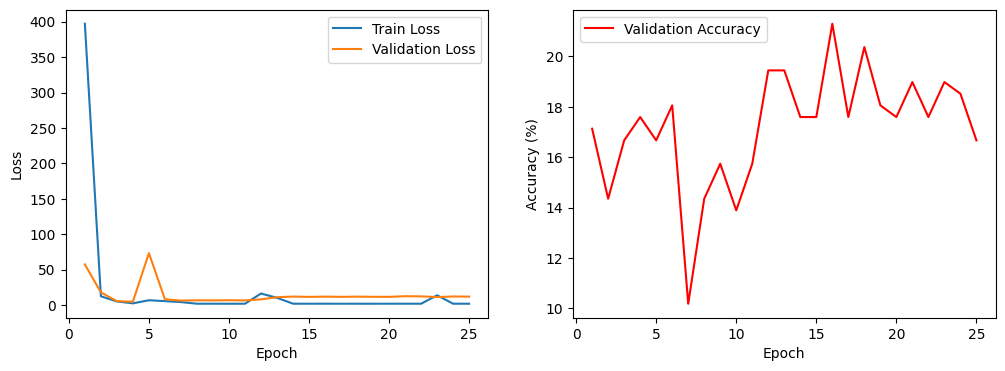

In [53]:
# Determine the x-axis range based on the number of epochs
x_range = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, train_losses_aug[:num_epochs], label='Train Loss')
plt.plot(x_range, val_losses_aug[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range, val_accuracies_aug[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Testing on test data

In [54]:
test_accuracy_aug, test_loss_aug = evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with Data Augmentation: {test_accuracy_aug:.2f}%')
print(f'Test Loss with Data Augmentation:  {np.mean(test_loss_aug):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


Test Accuracy with Data Augmentation penalty: 15.83%
Test Loss with Data Augmentation penalty:  4.9696


# Regularization with Dropout and Optimization with Adam

In [55]:
class NNModel_Dropout(nn.Module):
    def __init__(self):
        super(NNModel_Dropout, self).__init__()
        # Define three dense layers with ReLU activation and dropout
        self.input_layer = nn.Linear(64 * 64 * 3, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer with 20% probability
        self.hidden_layer1 = nn.Linear(1024, 12288)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # Dropout layer with 20% probability
        self.hidden_layer2 = nn.Linear(12288, 6)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.input_layer(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.hidden_layer1(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.hidden_layer2(x)
        return x


## Initializing model, training and optimization

In [56]:
modeld = NNModel_Dropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modeld.parameters(), lr=0.01)
num_epochs = EPOCHS

In [57]:
# Lists to store training loss, validation loss, and validation accuracy
train_losses_drp = []
val_losses_drp = []
val_accuracies_drp = []

for epoch in range(num_epochs):
    modeld.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = modeld(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses_drp.append(running_loss / len(train_loader))

    # Evaluate the model on the validation set and get validation loss and accuracy
    val_accuracy, val_loss = evaluate_per_epoch(modeld, val_loader, criterion)
    val_losses_drp.append(val_loss)  # Append the last validation loss
    val_accuracies_drp.append(val_accuracy)

    # Print and log the results for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_drp[-1]:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%')

print('Training completed.')

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


Epoch [1/25] - Train Loss: 849.2451 - Val Loss: 25.6297 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]


Epoch [2/25] - Train Loss: 5.9225 - Val Loss: 4.0468 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.80it/s]


Epoch [3/25] - Train Loss: 3.0949 - Val Loss: 4.2180 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.17it/s]


Epoch [4/25] - Train Loss: 2.8973 - Val Loss: 3.9032 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.91it/s]


Epoch [5/25] - Train Loss: 1.8240 - Val Loss: 3.8940 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.20it/s]


Epoch [6/25] - Train Loss: 1.8103 - Val Loss: 4.5369 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.35it/s]


Epoch [7/25] - Train Loss: 1.8107 - Val Loss: 3.8903 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.37it/s]


Epoch [8/25] - Train Loss: 1.8062 - Val Loss: 3.8860 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.94it/s]


Epoch [9/25] - Train Loss: 1.8043 - Val Loss: 3.8914 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


Epoch [10/25] - Train Loss: 1.7979 - Val Loss: 3.8892 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


Epoch [11/25] - Train Loss: 1.8071 - Val Loss: 3.8840 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.16it/s]


Epoch [12/25] - Train Loss: 1.8052 - Val Loss: 3.8849 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.37it/s]


Epoch [13/25] - Train Loss: 1.8020 - Val Loss: 3.8931 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Epoch [14/25] - Train Loss: 1.8021 - Val Loss: 3.8851 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.22it/s]


Epoch [15/25] - Train Loss: 1.8032 - Val Loss: 3.9369 - Val Accuracy: 16.20%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


Epoch [16/25] - Train Loss: 1.8051 - Val Loss: 3.8881 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


Epoch [17/25] - Train Loss: 1.8040 - Val Loss: 4.5294 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]


Epoch [18/25] - Train Loss: 1.7979 - Val Loss: 3.8825 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.13it/s]


Epoch [19/25] - Train Loss: 1.8039 - Val Loss: 3.8873 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


Epoch [20/25] - Train Loss: 1.8037 - Val Loss: 4.5317 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]


Epoch [21/25] - Train Loss: 1.8010 - Val Loss: 4.5306 - Val Accuracy: 16.20%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.59it/s]


Epoch [22/25] - Train Loss: 1.7994 - Val Loss: 3.8854 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.09it/s]


Epoch [23/25] - Train Loss: 1.8018 - Val Loss: 3.9348 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.82it/s]


Epoch [24/25] - Train Loss: 1.7957 - Val Loss: 3.8841 - Val Accuracy: 16.20%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.95it/s]

Epoch [25/25] - Train Loss: 1.7972 - Val Loss: 3.8860 - Val Accuracy: 14.35%
Training completed.


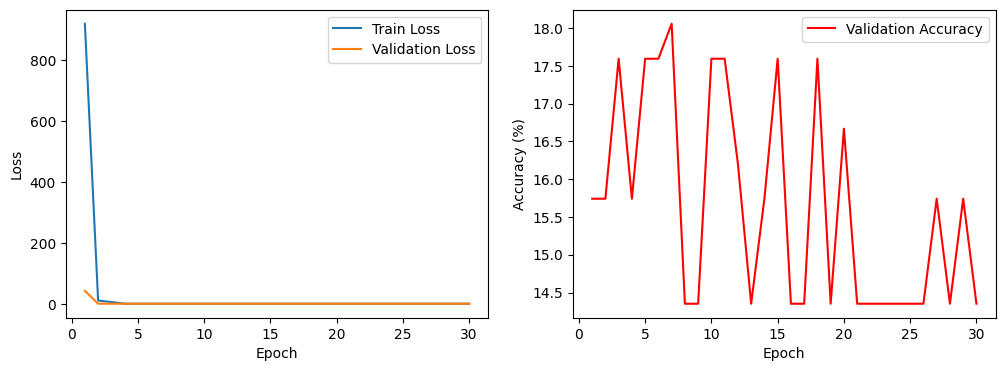

In [ ]:
# Determine the x-axis range based on the number of epochs
x_range = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, train_losses_drp[:num_epochs], label='Train Loss')
plt.plot(x_range, val_losses_drp[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range, val_accuracies_drp[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Testing on test data

In [ ]:
test_accuracy_drp, test_loss_drp= evaluate_per_epoch(modeld, test_loader, criterion)
print(f'\nTest Accuracy with Dropout: {test_accuracy_drp:.2f}%')
print(f'Test Loss with Dropout: {np.mean(test_loss_drp):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


Test Accuracy with L2-norm penalty: 16.67%
Test Loss with L2-norm penalty: 1.7924


# Experimenting with different Optimizers

## Gradient Descent

In [58]:
num_epochs=EPOCHS
weight_decay=0.001
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [59]:
# Training loop with evaluation and plotting
train_losses_l2_gd = []
val_losses_l2_gd = []
val_accuracies_l2_gd = []

for epoch in range(num_epochs):
    model.train()
    train_loss_gd = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_gd = criterion(outputs, labels)

        # Calculate L2-norm penalty
        l2_penalty_gd = 0.0
        for param in model.parameters():
            l2_penalty_gd += torch.norm(param, 2)

        loss_gd += weight_decay * l2_penalty_gd

        loss_gd.backward()
        optimizer.step()
        train_loss_gd += loss_gd.item()

    train_losses_l2_gd.append(train_loss_gd / len(train_loader))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_gd, val_loss_gd = evaluate_per_epoch(model, val_loader, criterion)
    val_losses_l2_gd.append(val_loss_gd)
    val_accuracies_l2_gd.append(val_accuracy_gd)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_l2_gd[-1]:.4f} - Val Loss: {val_loss_gd:.4f} - Val Accuracy: {val_accuracy_gd:.2f}%')


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.88it/s]


Epoch [1/25] - Train Loss: 3.6165 - Val Loss: 2.6680 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.28it/s]


Epoch [2/25] - Train Loss: 2.4831 - Val Loss: 2.1361 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.37it/s]


Epoch [3/25] - Train Loss: 2.3019 - Val Loss: 1.9792 - Val Accuracy: 25.93%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.77it/s]


Epoch [4/25] - Train Loss: 2.2493 - Val Loss: 1.9734 - Val Accuracy: 20.83%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


Epoch [5/25] - Train Loss: 2.2278 - Val Loss: 1.9407 - Val Accuracy: 19.91%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.08it/s]


Epoch [6/25] - Train Loss: 2.2078 - Val Loss: 1.9318 - Val Accuracy: 23.15%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.18it/s]


Epoch [7/25] - Train Loss: 2.2139 - Val Loss: 1.9090 - Val Accuracy: 25.00%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


Epoch [8/25] - Train Loss: 2.1798 - Val Loss: 1.8627 - Val Accuracy: 36.57%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.27it/s]


Epoch [9/25] - Train Loss: 2.1479 - Val Loss: 1.9229 - Val Accuracy: 21.30%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.93it/s]


Epoch [10/25] - Train Loss: 2.1491 - Val Loss: 1.8037 - Val Accuracy: 31.48%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 13.47it/s]


Epoch [11/25] - Train Loss: 2.1003 - Val Loss: 1.9265 - Val Accuracy: 23.15%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.34it/s]


Epoch [12/25] - Train Loss: 2.1980 - Val Loss: 1.9472 - Val Accuracy: 27.31%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s]


Epoch [13/25] - Train Loss: 2.1457 - Val Loss: 1.7465 - Val Accuracy: 36.11%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.15it/s]


Epoch [14/25] - Train Loss: 2.0282 - Val Loss: 1.7435 - Val Accuracy: 39.81%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]


Epoch [15/25] - Train Loss: 2.0064 - Val Loss: 1.7337 - Val Accuracy: 35.19%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.33it/s]


Epoch [16/25] - Train Loss: 1.9852 - Val Loss: 1.7501 - Val Accuracy: 29.63%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]


Epoch [17/25] - Train Loss: 1.9445 - Val Loss: 1.7451 - Val Accuracy: 41.67%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.88it/s]


Epoch [18/25] - Train Loss: 1.9201 - Val Loss: 1.6549 - Val Accuracy: 36.57%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.39it/s]


Epoch [19/25] - Train Loss: 1.9586 - Val Loss: 1.6946 - Val Accuracy: 41.67%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.23it/s]


Epoch [20/25] - Train Loss: 1.8346 - Val Loss: 1.5943 - Val Accuracy: 47.69%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.51it/s]


Epoch [21/25] - Train Loss: 1.8099 - Val Loss: 1.6132 - Val Accuracy: 40.28%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.02it/s]


Epoch [22/25] - Train Loss: 1.7932 - Val Loss: 1.6407 - Val Accuracy: 41.67%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


Epoch [23/25] - Train Loss: 1.8319 - Val Loss: 1.4930 - Val Accuracy: 52.31%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 15.37it/s]


Epoch [24/25] - Train Loss: 1.6837 - Val Loss: 1.5331 - Val Accuracy: 43.06%


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 14.97it/s]

Epoch [25/25] - Train Loss: 1.5849 - Val Loss: 1.4837 - Val Accuracy: 52.31%


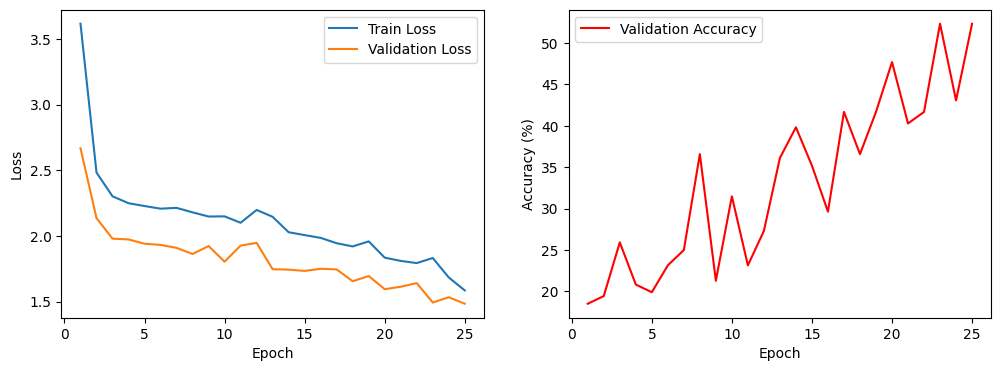

In [60]:
# Determine the x-axis range based on the number of epochs
x_range = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, train_losses_l2_gd[:num_epochs], label='Train Loss')
plt.plot(x_range, val_losses_l2_gd[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range, val_accuracies_l2_gd[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [61]:
test_accuracy_l2_gd, test_loss_l2_gd= evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with L2-norm penalty: {test_accuracy_l2_gd:.2f}%')
print(f'Test Loss with L2-norm penalty: {np.mean(test_loss_l2_gd):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 10.33it/s]


Test Accuracy with L2-norm penalty: 54.17%
Test Loss with L2-norm penalty: 1.2710


##Stochastic Gradient Descent (1 example)

In [62]:
num_epochs = EPOCHS
weight_decay = 0.001
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


#### Setting the batch size

In [63]:
# Modify the data loaders to use a batch size of 1 for SGD with single examples
train_loader_sgd_1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader_sgd_1 = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader_sgd_1 = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [64]:
# Training loop with evaluation and plotting
train_losses_l2_sgd_1 = []
val_losses_l2_sgd_1 = []
val_accuracies_l2_sgd_1 = []

for epoch in range(num_epochs):
    model.train()
    train_loss_sgd_1 = 0.0
    for inputs, labels in tqdm(train_loader_sgd_1, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_sgd_1 = criterion(outputs, labels)

        # Calculate L2-norm penalty
        l2_penalty_sgd_1 = 0.0
        for param in model.parameters():
            l2_penalty_sgd_1 += torch.norm(param, 2)

        loss_sgd_1 += weight_decay * l2_penalty_sgd_1

        loss_sgd_1.backward()
        optimizer.step()
        train_loss_sgd_1 += loss_sgd_1.item()

    train_losses_l2_sgd_1.append(train_loss_sgd_1 / len(train_loader_sgd_1))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_sgd_1, val_loss_sgd_1 = evaluate_per_epoch(model, val_loader_sgd_1, criterion)
    val_losses_l2_sgd_1.append(val_loss_sgd_1)
    val_accuracies_l2_sgd_1.append(val_accuracy_sgd_1)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_l2_sgd_1[-1]:.4f} - Val Loss: {val_loss_sgd_1:.4f} - Val Accuracy: {val_accuracy_sgd_1:.2f}%')


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 90.59it/s]


Epoch [1/25] - Train Loss: 2.3235 - Val Loss: 1.8579 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 84.62it/s]


Epoch [2/25] - Train Loss: 2.2518 - Val Loss: 1.8581 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 90.38it/s]


Epoch [3/25] - Train Loss: 2.2414 - Val Loss: 1.8584 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 72.41it/s]


Epoch [4/25] - Train Loss: 2.2404 - Val Loss: 1.8576 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 89.13it/s]


Epoch [5/25] - Train Loss: 2.2407 - Val Loss: 1.8580 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 92.40it/s]


Epoch [6/25] - Train Loss: 2.2402 - Val Loss: 1.8587 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 92.68it/s]


Epoch [7/25] - Train Loss: 2.2397 - Val Loss: 1.8583 - Val Accuracy: 13.89%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 78.41it/s]


Epoch [8/25] - Train Loss: 2.2394 - Val Loss: 1.8583 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 88.41it/s]


Epoch [9/25] - Train Loss: 2.2388 - Val Loss: 1.8572 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 77.18it/s]


Epoch [10/25] - Train Loss: 2.2382 - Val Loss: 1.8575 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 89.97it/s]


Epoch [11/25] - Train Loss: 2.2383 - Val Loss: 1.8572 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 76.44it/s]


Epoch [12/25] - Train Loss: 2.2374 - Val Loss: 1.8575 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 87.07it/s]


Epoch [13/25] - Train Loss: 2.2375 - Val Loss: 1.8566 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 84.89it/s]


Epoch [14/25] - Train Loss: 2.2369 - Val Loss: 1.8565 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 78.28it/s]


Epoch [15/25] - Train Loss: 2.2365 - Val Loss: 1.8557 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 90.28it/s]


Epoch [16/25] - Train Loss: 2.2363 - Val Loss: 1.8562 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 76.02it/s]


Epoch [17/25] - Train Loss: 2.2356 - Val Loss: 1.8561 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 89.42it/s]


Epoch [18/25] - Train Loss: 2.2352 - Val Loss: 1.8556 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 78.48it/s]


Epoch [19/25] - Train Loss: 2.2348 - Val Loss: 1.8562 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 82.18it/s]


Epoch [20/25] - Train Loss: 2.2343 - Val Loss: 1.8562 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 78.51it/s]


Epoch [21/25] - Train Loss: 2.2343 - Val Loss: 1.8552 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 79.98it/s]


Epoch [22/25] - Train Loss: 2.2336 - Val Loss: 1.8551 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 85.32it/s]


Epoch [23/25] - Train Loss: 2.2335 - Val Loss: 1.8543 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 89.52it/s]


Epoch [24/25] - Train Loss: 2.2326 - Val Loss: 1.8551 - Val Accuracy: 16.20%


Evaluation: 100%|██████████| 216/216 [00:02<00:00, 87.35it/s]

Epoch [25/25] - Train Loss: 2.2323 - Val Loss: 1.8563 - Val Accuracy: 14.35%


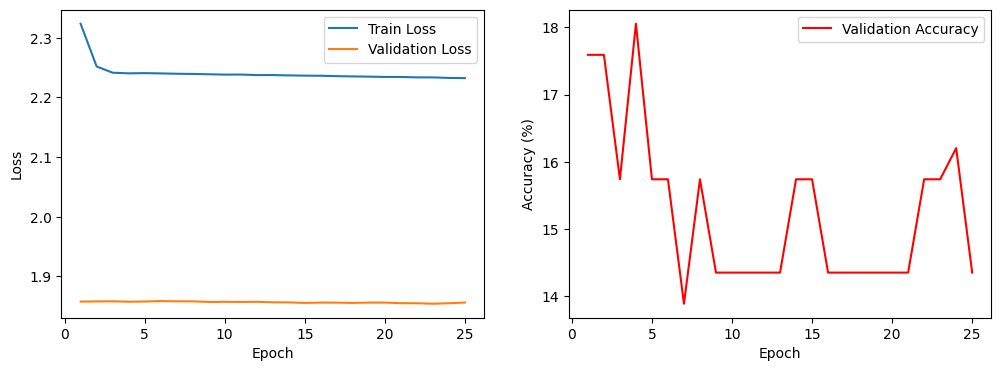

In [65]:
# Determine the x-axis range based on the number of epochs
x_range_sgd_1 = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range_sgd_1, train_losses_l2_sgd_1[:num_epochs], label='Train Loss')
plt.plot(x_range_sgd_1, val_losses_l2_sgd_1[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range_sgd_1, val_accuracies_l2_sgd_1[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [66]:
test_accuracy_l2_sgd_1, test_loss_l2_sgd_1 = evaluate_per_epoch(model, test_loader_sgd_1, criterion)
print(f'\nTest Accuracy with L2-norm penalty (SGD with batch size 1): {test_accuracy_l2_sgd_1:.2f}%')
print(f'Test Loss with L2-norm penalty (SGD with batch size 1): {np.mean(test_loss_l2_sgd_1):.4f}')

Evaluation: 100%|██████████| 120/120 [00:01<00:00, 76.75it/s]


Test Accuracy with L2-norm penalty (SGD with batch size 1): 17.50%
Test Loss with L2-norm penalty (SGD with batch size 1): 1.7773


### SGD with Minibatches (using minibatch size 64)

In [67]:
num_epochs = EPOCHS
weight_decay = 0.001
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [68]:
batch_size = 64
train_loader_sgd_mini = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_sgd_mini = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_sgd_mini = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
# Training loop with evaluation and plotting
train_losses_l2_sgd_mini = []
val_losses_l2_sgd_mini = []
val_accuracies_l2_sgd_mini = []

for epoch in range(num_epochs):
    model.train()
    train_loss_sgd_mini = 0.0
    for inputs, labels in tqdm(train_loader_sgd_mini, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_sgd_mini = criterion(outputs, labels)

        # Calculate L2-norm penalty
        l2_penalty_sgd_mini = 0.0
        for param in model.parameters():
            l2_penalty_sgd_mini += torch.norm(param, 2)

        loss_sgd_mini += weight_decay * l2_penalty_sgd_mini

        loss_sgd_mini.backward()
        optimizer.step()
        train_loss_sgd_mini += loss_sgd_mini.item()

    train_losses_l2_sgd_mini.append(train_loss_sgd_mini / len(train_loader_sgd_mini))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_sgd_mini, val_losses_sgd_mini = evaluate_per_epoch(model, val_loader_sgd_mini, criterion)
    val_losses_l2_sgd_mini.append(val_losses_sgd_mini)
    val_accuracies_l2_sgd_mini.append(val_accuracy_sgd_mini)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_l2_sgd_mini[-1]:.4f} - Val Loss: {val_losses_sgd_mini:.6f} - Val Accuracy: {val_accuracy_sgd_mini:.2f}%')


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [1/25] - Train Loss: 2.2308 - Val Loss: 1.846583 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Epoch [2/25] - Train Loss: 2.2303 - Val Loss: 1.846548 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.53it/s]


Epoch [3/25] - Train Loss: 2.2307 - Val Loss: 1.846494 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.45it/s]


Epoch [4/25] - Train Loss: 2.2295 - Val Loss: 1.846482 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [5/25] - Train Loss: 2.2308 - Val Loss: 1.846424 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


Epoch [6/25] - Train Loss: 2.2310 - Val Loss: 1.846361 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch [7/25] - Train Loss: 2.2306 - Val Loss: 1.846310 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


Epoch [8/25] - Train Loss: 2.2305 - Val Loss: 1.846261 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Epoch [9/25] - Train Loss: 2.2301 - Val Loss: 1.846227 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch [10/25] - Train Loss: 2.2312 - Val Loss: 1.846164 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [11/25] - Train Loss: 2.2303 - Val Loss: 1.846132 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


Epoch [12/25] - Train Loss: 2.2304 - Val Loss: 1.846094 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


Epoch [13/25] - Train Loss: 2.2307 - Val Loss: 1.846045 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


Epoch [14/25] - Train Loss: 2.2302 - Val Loss: 1.846015 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Epoch [15/25] - Train Loss: 2.2305 - Val Loss: 1.845969 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.66it/s]


Epoch [16/25] - Train Loss: 2.2306 - Val Loss: 1.845920 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.56it/s]


Epoch [17/25] - Train Loss: 2.2306 - Val Loss: 1.845872 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Epoch [18/25] - Train Loss: 2.2302 - Val Loss: 1.845840 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.96it/s]


Epoch [19/25] - Train Loss: 2.2304 - Val Loss: 1.845800 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.98it/s]


Epoch [20/25] - Train Loss: 2.2304 - Val Loss: 1.845756 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch [21/25] - Train Loss: 2.2301 - Val Loss: 1.845734 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


Epoch [22/25] - Train Loss: 2.2302 - Val Loss: 1.845701 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]


Epoch [23/25] - Train Loss: 2.2302 - Val Loss: 1.845667 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.47it/s]


Epoch [24/25] - Train Loss: 2.2305 - Val Loss: 1.845625 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.98it/s]

Epoch [25/25] - Train Loss: 2.2298 - Val Loss: 1.845617 - Val Accuracy: 14.35%


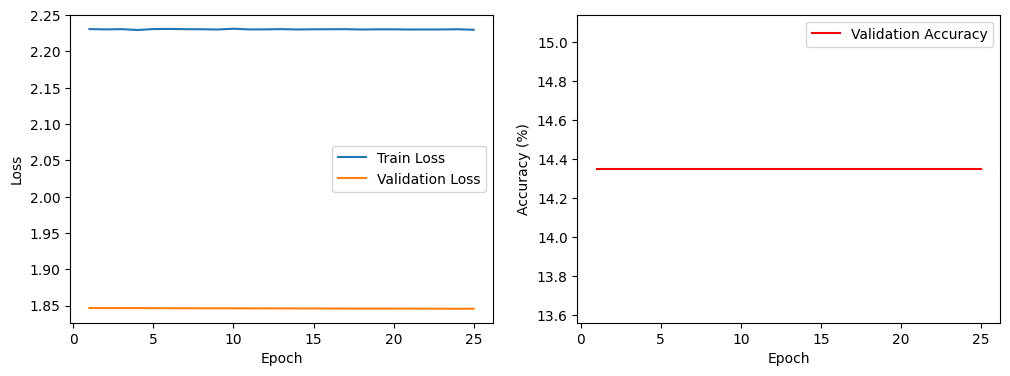

In [70]:
# Determine the x-axis range based on the number of epochs
x_range_sgd_mini = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range_sgd_mini, train_losses_l2_sgd_mini[:num_epochs], label='Train Loss')
plt.plot(x_range_sgd_mini, val_losses_l2_sgd_mini[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range_sgd_mini, val_accuracies_l2_sgd_mini[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [71]:

test_accuracy_l2_sgd_mini, test_loss_l2_sgd_mini = evaluate_per_epoch(model, test_loader_sgd_mini, criterion)
print(f'\nTest Accuracy with L2-norm penalty (SGD with minibatch size {batch_size}): {test_accuracy_l2_sgd_mini:.2f}%')
print(f'Test Loss with L2-norm penalty (SGD with minibatch size {batch_size}): {np.mean(test_loss_l2_sgd_mini):.4f}')

Evaluation: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Test Accuracy with L2-norm penalty (SGD with minibatch size 64): 17.50%
Test Loss with L2-norm penalty (SGD with minibatch size 64): 1.7778


### AdaGrad Optimization

In [72]:
num_epochs = EPOCHS
weight_decay = 0.001
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Use AdaGrad

In [73]:
# Training loop with evaluation and plotting
train_losses_l2_ada = []
val_losses_l2_ada = []
val_accuracies_l2_ada = []

for epoch in range(num_epochs):
    model.train()
    train_loss_ada = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_ada = criterion(outputs, labels)

        # Calculate L2-norm penalty
        l2_penalty_ada = 0.0
        for param in model.parameters():
            l2_penalty_ada += torch.norm(param, 2)

        loss_ada += weight_decay * l2_penalty_ada

        loss_ada.backward()
        optimizer.step()
        train_loss_ada += loss_ada.item()

    train_losses_l2_ada.append(train_loss_ada / len(train_loader))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_ada, val_losses_ada = evaluate_per_epoch(model, val_loader, criterion)
    val_losses_l2_ada.append(val_losses_ada)
    val_accuracies_l2_ada.append(val_accuracy_ada)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_l2_ada[-1]:.4f} - Val Loss: {val_losses_ada:.4f} - Val Accuracy: {val_accuracy_ada:.2f}%')

Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch [1/25] - Train Loss: 28.8647 - Val Loss: 1.7949 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]


Epoch [2/25] - Train Loss: 1.9009 - Val Loss: 15.0722 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch [3/25] - Train Loss: 3.0818 - Val Loss: 1.7912 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch [4/25] - Train Loss: 3.1329 - Val Loss: 1.7955 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [5/25] - Train Loss: 2.8737 - Val Loss: 1.6793 - Val Accuracy: 25.93%


Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch [6/25] - Train Loss: 2.4800 - Val Loss: 1.8427 - Val Accuracy: 17.13%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Epoch [7/25] - Train Loss: 1.9502 - Val Loss: 6.1669 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [8/25] - Train Loss: 2.6857 - Val Loss: 1.7941 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch [9/25] - Train Loss: 2.8116 - Val Loss: 1.7849 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch [10/25] - Train Loss: 2.3983 - Val Loss: 1.7954 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Epoch [11/25] - Train Loss: 2.3711 - Val Loss: 1.7145 - Val Accuracy: 29.17%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch [12/25] - Train Loss: 2.9094 - Val Loss: 2.4703 - Val Accuracy: 19.91%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [13/25] - Train Loss: 2.3367 - Val Loss: 5.1888 - Val Accuracy: 16.20%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch [14/25] - Train Loss: 2.0009 - Val Loss: 1.4976 - Val Accuracy: 33.80%


Evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch [15/25] - Train Loss: 2.3242 - Val Loss: 1.5789 - Val Accuracy: 33.33%


Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch [16/25] - Train Loss: 2.0228 - Val Loss: 1.4457 - Val Accuracy: 38.89%


Evaluation: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch [17/25] - Train Loss: 1.9919 - Val Loss: 1.4047 - Val Accuracy: 42.13%


Evaluation: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch [18/25] - Train Loss: 1.3579 - Val Loss: 1.3166 - Val Accuracy: 46.30%


Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


Epoch [19/25] - Train Loss: 1.3320 - Val Loss: 1.2491 - Val Accuracy: 48.61%


Evaluation: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [20/25] - Train Loss: 1.3917 - Val Loss: 1.1344 - Val Accuracy: 54.17%


Evaluation: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Epoch [21/25] - Train Loss: 1.1821 - Val Loss: 4.1838 - Val Accuracy: 27.31%


Evaluation: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Epoch [22/25] - Train Loss: 1.4370 - Val Loss: 1.1108 - Val Accuracy: 53.24%


Evaluation: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Epoch [23/25] - Train Loss: 1.6812 - Val Loss: 1.9500 - Val Accuracy: 36.11%


Evaluation: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Epoch [24/25] - Train Loss: 1.1873 - Val Loss: 2.9565 - Val Accuracy: 36.11%


Evaluation: 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

Epoch [25/25] - Train Loss: 2.0163 - Val Loss: 1.1194 - Val Accuracy: 54.17%


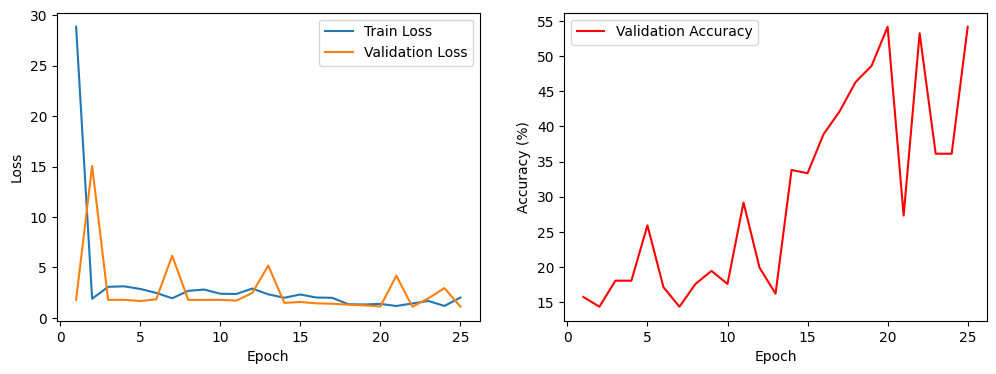

In [74]:

# Determine the x-axis range based on the number of epochs
x_range_ada = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range_ada, train_losses_l2_ada[:num_epochs], label='Train Loss')
plt.plot(x_range_ada, val_losses_l2_ada[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range_ada, val_accuracies_l2_ada[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [75]:
test_accuracy_l2_ada, test_loss_l2_ada = evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with L2-norm penalty (AdaGrad): {test_accuracy_l2_ada:.2f}%')
print(f'Test Loss with L2-norm penalty (AdaGrad): {np.mean(test_loss_l2_ada):.4f}')

Evaluation: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Test Accuracy with L2-norm penalty (AdaGrad): 51.67%
Test Loss with L2-norm penalty (AdaGrad): 1.1335


### RMSProp

In [76]:
num_epochs = EPOCHS
weight_decay = 0.001
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Use RMSProp


In [77]:
# Training loop with evaluation and plotting
train_losses_l2_rmsprop = []
val_losses_l2_rmsprop = []
val_accuracies_l2_rmsprop = []

for epoch in range(num_epochs):
    model.train()
    train_loss_rmsprop = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer_rmsprop.zero_grad()
        outputs = model(inputs)
        loss_rmsprop = criterion(outputs, labels)

        # Calculate L2-norm penalty
        l2_penalty_rmsprop = 0.0
        for param in model.parameters():
            l2_penalty_rmsprop += torch.norm(param, 2)

        loss_rmsprop += weight_decay * l2_penalty_rmsprop

        loss_rmsprop.backward()
        optimizer_rmsprop.step()
        train_loss_rmsprop += loss_rmsprop.item()

    train_losses_l2_rmsprop.append(train_loss_rmsprop / len(train_loader))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_rmsprop, val_losses_rmsprop = evaluate_per_epoch(model, val_loader, criterion)
    val_losses_l2_rmsprop.append(val_losses_rmsprop)
    val_accuracies_l2_rmsprop.append(val_accuracy_rmsprop)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_l2_rmsprop[-1]:.4f} - Val Loss: {val_losses_rmsprop:.4f} - Val Accuracy: {val_accuracy_rmsprop:.2f}%')


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


Epoch [1/25] - Train Loss: 1310.9422 - Val Loss: 3.2965 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]


Epoch [2/25] - Train Loss: 1.9500 - Val Loss: 1.6748 - Val Accuracy: 25.46%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


Epoch [3/25] - Train Loss: 4.4049 - Val Loss: 1.6601 - Val Accuracy: 26.39%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


Epoch [4/25] - Train Loss: 3.4851 - Val Loss: 1.6417 - Val Accuracy: 26.85%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch [5/25] - Train Loss: 17.0874 - Val Loss: 1.7796 - Val Accuracy: 25.46%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch [6/25] - Train Loss: 10.4150 - Val Loss: 31.4888 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch [7/25] - Train Loss: 15.7536 - Val Loss: 1.8380 - Val Accuracy: 12.96%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Epoch [8/25] - Train Loss: 1.9836 - Val Loss: 1.7869 - Val Accuracy: 16.67%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.28it/s]


Epoch [9/25] - Train Loss: 1.7821 - Val Loss: 1.7488 - Val Accuracy: 25.00%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch [10/25] - Train Loss: 4.0343 - Val Loss: 1.8913 - Val Accuracy: 25.00%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.34it/s]


Epoch [11/25] - Train Loss: 6.8606 - Val Loss: 1.7580 - Val Accuracy: 21.76%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch [12/25] - Train Loss: 1.8720 - Val Loss: 1.7203 - Val Accuracy: 24.54%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch [13/25] - Train Loss: 4.5232 - Val Loss: 5.1664 - Val Accuracy: 27.78%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch [14/25] - Train Loss: 3.0297 - Val Loss: 1.7050 - Val Accuracy: 28.24%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch [15/25] - Train Loss: 3.5002 - Val Loss: 1.7183 - Val Accuracy: 25.93%


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch [16/25] - Train Loss: 2.3686 - Val Loss: 1.7408 - Val Accuracy: 29.17%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


Epoch [17/25] - Train Loss: 3.2675 - Val Loss: 25.8213 - Val Accuracy: 23.15%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch [18/25] - Train Loss: 3.4863 - Val Loss: 1.7558 - Val Accuracy: 22.69%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch [19/25] - Train Loss: 6.5357 - Val Loss: 1.8831 - Val Accuracy: 20.83%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch [20/25] - Train Loss: 5.3554 - Val Loss: 1.8349 - Val Accuracy: 20.83%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]


Epoch [21/25] - Train Loss: 3.7756 - Val Loss: 1.8159 - Val Accuracy: 22.69%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


Epoch [22/25] - Train Loss: 6.3779 - Val Loss: 1.7268 - Val Accuracy: 20.83%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch [23/25] - Train Loss: 3.0926 - Val Loss: 1.6595 - Val Accuracy: 25.00%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


Epoch [24/25] - Train Loss: 4.6726 - Val Loss: 1.7134 - Val Accuracy: 28.24%


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

Epoch [25/25] - Train Loss: 6.5569 - Val Loss: 16.2546 - Val Accuracy: 21.76%


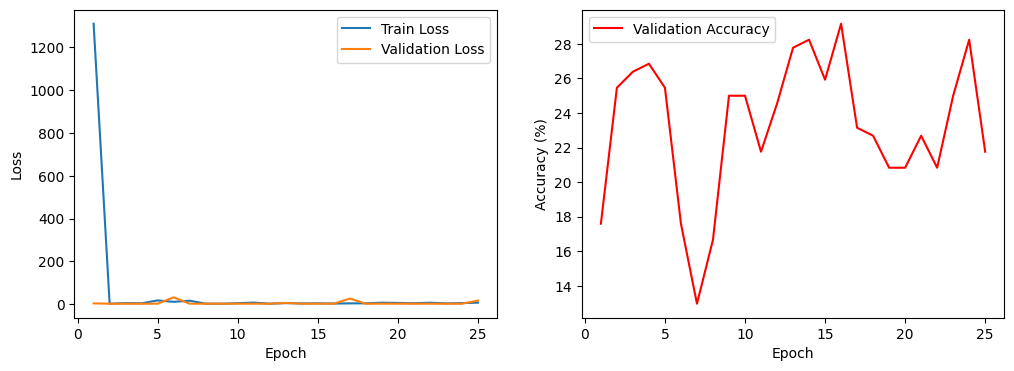

In [78]:
# Determine the x-axis range based on the number of epochs
x_range_rmsprop = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range_rmsprop, train_losses_l2_rmsprop[:num_epochs], label='Train Loss')
plt.plot(x_range_rmsprop, val_losses_l2_rmsprop[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range_rmsprop, val_accuracies_l2_rmsprop[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [79]:
test_accuracy_l2_rmsprop, test_loss_l2_rmsprop = evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with L2-norm penalty (RMSProp): {test_accuracy_l2_rmsprop:.2f}%')
print(f'Test Loss with L2-norm penalty (RMSProp): {np.mean(test_loss_l2_rmsprop):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Test Accuracy with L2-norm penalty (RMSProp): 19.17%
Test Loss with L2-norm penalty (RMSProp): 17.3738


### RMSProp with Momentum

In [80]:
num_epochs = EPOCHS
weight_decay = 0.001  # Weight decay (L2 penalty)
learning_rate = 0.01  # Initial learning rate
momentum = 0.90  # Momentum coefficient
criterion = nn.CrossEntropyLoss()
optimizer_rmsprop_with_momentum = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [81]:

# Training loop with evaluation and plotting
train_losses_rmsprop_with_momentum = []
val_losses_rmsprop_with_momentum = []
val_accuracies_rmsprop_with_momentum = []

for epoch in range(num_epochs):
    model.train()
    train_loss_rmsprop_with_momentum = 0.0
    for inputs, labels in tqdm(train_loader_sgd_mini, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer_rmsprop_with_momentum.zero_grad()
        outputs = model(inputs)
        loss_rmsprop = criterion(outputs, labels)

        # Calculate L2-norm penalty (weight decay)
        l2_penalty_rmsprop = 0.0
        for param in model.parameters():
            l2_penalty_rmsprop += torch.norm(param, 2)

        loss_rmsprop += weight_decay * l2_penalty_rmsprop

        loss_rmsprop.backward()
        optimizer_rmsprop_with_momentum.step()
        train_loss_rmsprop_with_momentum += loss_rmsprop.item()

    train_losses_rmsprop_with_momentum.append(train_loss_rmsprop_with_momentum / len(train_loader))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_rmsprop_with_momentum, val_losses_rmsprop_momentum = evaluate_per_epoch(model, val_loader_sgd_mini, criterion)
    val_losses_rmsprop_with_momentum.append(val_losses_rmsprop_momentum)
    val_accuracies_rmsprop_with_momentum.append(val_accuracy_rmsprop_with_momentum)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_rmsprop_with_momentum[-1]:.4f} - Val Loss: {val_losses_rmsprop_momentum:.4f} - Val Accuracy: {val_accuracy_rmsprop_with_momentum:.2f}%')


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]


Epoch [1/25] - Train Loss: 5827002.7951 - Val Loss: 144.1641 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.37it/s]


Epoch [2/25] - Train Loss: 224.4259 - Val Loss: 169.5658 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch [3/25] - Train Loss: 60.1798 - Val Loss: 114.8223 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]


Epoch [4/25] - Train Loss: 61.2239 - Val Loss: 78.3735 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Epoch [5/25] - Train Loss: 36.8460 - Val Loss: 36.7744 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00, 10.18it/s]


Epoch [6/25] - Train Loss: 26.5914 - Val Loss: 45.9713 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch [7/25] - Train Loss: 30.5282 - Val Loss: 36.2232 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.51it/s]


Epoch [8/25] - Train Loss: 23.7385 - Val Loss: 55.7950 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch [9/25] - Train Loss: 43.9080 - Val Loss: 61.0185 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.46it/s]


Epoch [10/25] - Train Loss: 26.1825 - Val Loss: 30.4197 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


Epoch [11/25] - Train Loss: 24.8631 - Val Loss: 75.0456 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch [12/25] - Train Loss: 33.2939 - Val Loss: 80.5039 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch [13/25] - Train Loss: 25.6055 - Val Loss: 39.0457 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [14/25] - Train Loss: 28.0197 - Val Loss: 49.6774 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.99it/s]


Epoch [15/25] - Train Loss: 24.8975 - Val Loss: 13.2227 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


Epoch [16/25] - Train Loss: 21.4500 - Val Loss: 57.7765 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  7.64it/s]


Epoch [17/25] - Train Loss: 29.4000 - Val Loss: 62.2933 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]


Epoch [18/25] - Train Loss: 29.1090 - Val Loss: 29.7024 - Val Accuracy: 14.35%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


Epoch [19/25] - Train Loss: 23.7065 - Val Loss: 46.3529 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch [20/25] - Train Loss: 23.7053 - Val Loss: 30.4453 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.61it/s]


Epoch [21/25] - Train Loss: 22.2929 - Val Loss: 20.3941 - Val Accuracy: 17.59%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch [22/25] - Train Loss: 28.1723 - Val Loss: 21.2237 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.49it/s]


Epoch [23/25] - Train Loss: 30.9108 - Val Loss: 72.8568 - Val Accuracy: 15.74%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]


Epoch [24/25] - Train Loss: 22.2268 - Val Loss: 34.4881 - Val Accuracy: 16.67%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

Epoch [25/25] - Train Loss: 24.5833 - Val Loss: 62.8974 - Val Accuracy: 16.67%


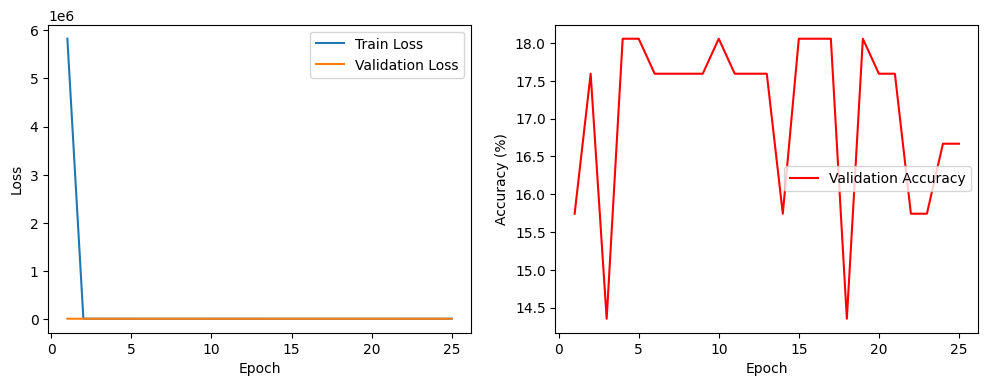

In [82]:
# Determine the x-axis range based on the number of epochs
x_range_rmsprop_with_momentum = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range_rmsprop_with_momentum, train_losses_rmsprop_with_momentum[:num_epochs], label='Train Loss')
plt.plot(x_range_rmsprop_with_momentum, val_losses_rmsprop_with_momentum[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range_rmsprop_with_momentum, val_accuracies_rmsprop_with_momentum[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [83]:
# Evaluate the model on the test set
test_accuracy_rmsprop_with_momentum, test_losses_rmsprop_with_momentum = evaluate_per_epoch(model, test_loader, criterion)
print(f'\nTest Accuracy with L2-norm penalty (RMSProp with Momentum and Weight Decay): {test_accuracy_rmsprop_with_momentum:.2f}%')
print(f'Test Loss with L2-norm penalty (RMSProp with Momentum and Weight Decay): {np.mean(test_losses_rmsprop_with_momentum):.4f}')

Evaluation: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s]


Test Accuracy with L2-norm penalty (RMSProp with Momentum and Weight Decay): 16.67%
Test Loss with L2-norm penalty (RMSProp with Momentum and Weight Decay): 67.8044


### Batch Normalization

In [84]:
import torch
import torch.nn as nn

class NNModelWithBatchNorm(nn.Module):
    def __init__(self):
        super(NNModelWithBatchNorm, self).__init__()
        # Define three dense layers with ReLU activation and BatchNorm
        self.input_layer = nn.Linear(64 * 64 * 3, 1024)  # Input size: 64x64x3
        self.bn1 = nn.BatchNorm1d(1024)  # BatchNorm layer after the first fully connected layer
        self.relu1 = nn.ReLU()
        self.hidden_layer1 = nn.Linear(1024, 12288)
        self.bn2 = nn.BatchNorm1d(12288)  # BatchNorm layer after the second fully connected layer
        self.relu2 = nn.ReLU()
        self.hidden_layer2 = nn.Linear(12288, 6)  # Output layer with 6 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.input_layer(x)
        x = self.bn1(x)  # Apply BatchNorm
        x = self.relu1(x)
        x = self.hidden_layer1(x)
        x = self.bn2(x)  # Apply BatchNorm
        x = self.relu2(x)
        x = self.hidden_layer2(x)
        return x


In [85]:
num_epochs = EPOCHS
weight_decay = 0.001
learning_rate = 0.01

# Create an instance of the model
model_bn = NNModelWithBatchNorm()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [86]:
# Training loop with evaluation and plotting
train_losses_bn= []
val_losses_bn= []
val_accuracies_bn= []

for epoch in range(num_epochs):
    model_bn.train()
    train_loss_bn= 0.0
    for inputs, labels in tqdm(train_loader_sgd_mini, desc=f'Epoch [{epoch + 1}/{num_epochs}]'):
        optimizer.zero_grad()
        outputs = model_bn(inputs)
        loss_bn= criterion(outputs, labels)

        # Calculate L2-norm penalty (weight decay)
        l2_penalty_bn= 0.0
        for param in model.parameters():
            l2_penalty_bn += torch.norm(param, 2)

        loss_bn += weight_decay * l2_penalty_bn

        loss_bn.backward()
        optimizer.step()
        train_loss_bn += loss_bn.item()

    train_losses_bn.append(train_loss_bn / len(train_loader))

    # Evaluate the model after each epoch and collect accuracy and loss
    val_accuracy_bn, val_loss_bn= evaluate_per_epoch(model_bn, val_loader_sgd_mini, criterion)
    val_losses_bn.append(val_loss_bn)
    val_accuracies_bn.append(val_accuracy_bn)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses_bn[-1]:.4f} - Val Loss: {val_loss_bn:.4f} - Val Accuracy: {val_accuracy_bn:.2f}%')


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Epoch [1/25] - Train Loss: 4.8759 - Val Loss: 1.7903 - Val Accuracy: 21.30%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.86it/s]


Epoch [2/25] - Train Loss: 4.8741 - Val Loss: 1.7986 - Val Accuracy: 19.91%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


Epoch [3/25] - Train Loss: 4.8738 - Val Loss: 1.8100 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


Epoch [4/25] - Train Loss: 4.8691 - Val Loss: 1.8157 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.99it/s]


Epoch [5/25] - Train Loss: 4.8684 - Val Loss: 1.8170 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch [6/25] - Train Loss: 4.8717 - Val Loss: 1.8162 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


Epoch [7/25] - Train Loss: 4.8690 - Val Loss: 1.8169 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


Epoch [8/25] - Train Loss: 4.8720 - Val Loss: 1.8173 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


Epoch [9/25] - Train Loss: 4.8710 - Val Loss: 1.8160 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Epoch [10/25] - Train Loss: 4.8705 - Val Loss: 1.8154 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]


Epoch [11/25] - Train Loss: 4.8723 - Val Loss: 1.8161 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.43it/s]


Epoch [12/25] - Train Loss: 4.8701 - Val Loss: 1.8167 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  8.45it/s]


Epoch [13/25] - Train Loss: 4.8712 - Val Loss: 1.8153 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.96it/s]


Epoch [14/25] - Train Loss: 4.8693 - Val Loss: 1.8154 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]


Epoch [15/25] - Train Loss: 4.8687 - Val Loss: 1.8178 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch [16/25] - Train Loss: 4.8688 - Val Loss: 1.8148 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.68it/s]


Epoch [17/25] - Train Loss: 4.8670 - Val Loss: 1.8179 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.51it/s]


Epoch [18/25] - Train Loss: 4.8668 - Val Loss: 1.8173 - Val Accuracy: 18.06%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.91it/s]


Epoch [19/25] - Train Loss: 4.8656 - Val Loss: 1.8163 - Val Accuracy: 18.98%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


Epoch [20/25] - Train Loss: 4.8670 - Val Loss: 1.8147 - Val Accuracy: 19.91%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch [21/25] - Train Loss: 4.8652 - Val Loss: 1.8160 - Val Accuracy: 19.44%


Evaluation: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


Epoch [22/25] - Train Loss: 4.8630 - Val Loss: 1.8162 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.99it/s]


Epoch [23/25] - Train Loss: 4.8634 - Val Loss: 1.8165 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.86it/s]


Epoch [24/25] - Train Loss: 4.8601 - Val Loss: 1.8161 - Val Accuracy: 18.52%


Evaluation: 100%|██████████| 4/4 [00:00<00:00,  9.98it/s]

Epoch [25/25] - Train Loss: 4.8608 - Val Loss: 1.8162 - Val Accuracy: 18.98%


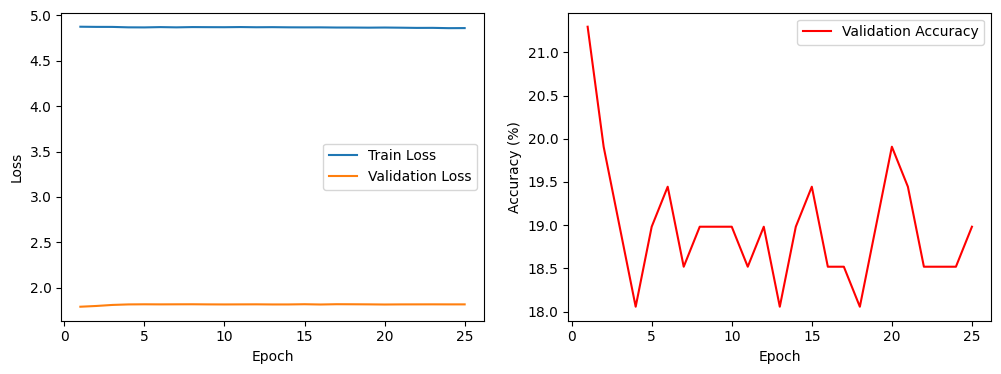

In [87]:
x_range_with_bn = range(1, num_epochs + 1)

# Plot loss and accuracy per epoch (limit x-axis to the number of epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range_with_bn, train_losses_bn[:num_epochs], label='Train Loss')
plt.plot(x_range_with_bn, val_losses_bn[:num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_range_with_bn, val_accuracies_bn[:num_epochs], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()




In [88]:
# Evaluate the model on the test set
test_accuracy_bn, test_losses_bn = evaluate_per_epoch(model_bn, test_loader_sgd_mini, criterion)
print(f'\nTest Accuracy with L2-norm penalty and BatchNorm: {test_accuracy_bn:.2f}%')
print(f'Test Loss with L2-norm penalty and BatchNorm: {np.mean(test_losses_bn):.4f}')

Evaluation: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


Test Accuracy with L2-norm penalty and BatchNorm: 15.83%
Test Loss with L2-norm penalty and BatchNorm: 1.8333
